In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import xgboost as xgb

# Outlier Analysis

TODO: We need to remove outlier

In [157]:
with open('balearic_frequency_cleaned.pkl', 'rb') as file:
    frequency_data_raw = pickle.load(file)

frequency_data_raw.index = frequency_data_raw.index.tz_localize('UTC')
frequency_data_raw.index = frequency_data_raw.index.tz_convert('Europe/Madrid')

frequency_data = frequency_data_raw.copy()

In [ ]:
frequency_data["frequency"].isna().sum()

In [159]:
frequency_data.dropna(inplace=True)

In [160]:
from events import get_events

positive_events = get_events(frequency_data=frequency_data, threshold=(frequency_data > 150), max_gap_length=5, event_end=0, event_start=5)
negative_events = get_events(frequency_data=frequency_data, threshold=(frequency_data < -150), max_gap_length=5, event_end=0, event_start=5)

In [163]:
from scraper import SpanishScraper


import os

if os.path.isfile("generation_data.pkl"):
    with open('generation_data.pkl', 'rb') as file:
        generation_data = pickle.load(file)
else:
    # select system and date range
    system = 'Baleares'
    startdate = '2019-09-29'
    enddate = '2023-07-01'

    # request data
    generation_data = SpanishScraper().get(system, startdate, enddate)
    generation_data.to_pickle("generation_data.pkl")  

In [164]:
scheduled_columns = [
    'generation_coal', 
    'generation_diesel_engines',
    'generation_gas_turbine', 
    'generation_combined_cycle',
    'generation_cogeneration',
    'generation_waste',
    'generation_auxiliary']

dynamic_columns = [
    'generation_solar',
    'generation_wind',
    'generation_other_renewables',
]

columns_to_drop = [
    'generation_waste',
    'generation_cogeneration',
    'generation_auxiliary',
    'generation_wind',
    'generation_other_renewables',
]

generation_data['generation_dynamic'] = generation_data[dynamic_columns].sum(axis=1)
generation_data['generation_scheduled'] = generation_data[scheduled_columns].sum(axis=1)

generation_data = generation_data.drop(columns=columns_to_drop)
#generation_data = generation_data.drop(columns=dynamic_columns)

In [168]:
frequency_data = frequency_data.to_frame()
frequency_data.rename(columns={0: 'frequency'}, inplace=True)


In [169]:
frequency_data_profile = frequency_data.copy()


# Step 2: Convert the DataFrame to have a single column if it doesn't already
# This step might not be necessary if your DataFrame already has a single frequency column
# frequency_data_profile = frequency_data_profile.to_frame() # This line might not be necessary
frequency_data_profile['time'] = frequency_data_profile.index.time

# Step 4: Group by the 'time' column and calculate the mean frequency for each time
data_day_profile = frequency_data_profile.groupby('time').mean()

# Assuming 'frequency' is the column with frequency values
# If your actual frequency column has a different name, replace 'frequency' with that name
data_day_profile = data_day_profile.rename(columns={"frequency": 'expected_frequency'})

# Step 5: Map the expected_frequency values back to the original DataFrame
frequency_data['expected_frequency'] = frequency_data_profile['time'].map(data_day_profile['expected_frequency'])

# This will add the expected_frequency column to your original DataFrame


In [170]:
frequency_data['ema_5_minutes'] = frequency_data['frequency'].ewm(span=300, adjust=True).mean()

In [171]:
frequency_data['ema_6_seconds'] = frequency_data['frequency'].ewm(span=6, adjust=True).mean()

In [172]:
frequency_data['ema_1_minute'] = frequency_data['frequency'].ewm(span=60, adjust=True).mean()

In [173]:
alpha = 0.1

In [174]:
frequency_data['squared_deviations_5_minutes'] = (frequency_data['frequency'] - frequency_data['ema_5_minutes'])**2
frequency_data['emv_5_minutes'] = frequency_data['squared_deviations_5_minutes'].ewm(alpha=alpha, adjust=False).mean()

In [175]:
frequency_data['squared_deviations_6_seconds'] = (frequency_data['frequency'] - frequency_data['ema_6_seconds'])**2
frequency_data['emv_6_seconds'] = frequency_data['squared_deviations_6_seconds'].ewm(alpha=alpha, adjust=False).mean()

In [176]:
frequency_data['squared_deviations_1_minute'] = (frequency_data['frequency'] - frequency_data['ema_1_minute'])**2
frequency_data['emv_1_minute'] = frequency_data['squared_deviations_1_minute'].ewm(alpha=alpha, adjust=False).mean()

In [177]:
frequency_data["ramp_frequency_6_seconds"] = frequency_data["frequency"].diff(periods = 6)

In [178]:
frequency_data["ramp_frequency_30_seconds"] = frequency_data["frequency"].diff(periods = 30)

In [179]:
generation_data["During_Event"] = 0

In [181]:
start = frequency_data.index.min()
end = frequency_data.index.max()

five_minute_intervals = pd.date_range(start=start, end=end, freq='5T')

# put the frequency data in a 5 minute interval
frequency_data_5min = frequency_data[frequency_data.index.isin(five_minute_intervals)]

In [182]:
# Zurücksetzen des Indexes und Überprüfen des Spaltennamens
generation_data_reset = generation_data.reset_index()
frequency_data_5min_df = frequency_data_5min.reset_index()

# Umbenennen der Spalte, die den alten Index enthält, falls erforderlich
generation_data_reset.rename(columns={generation_data_reset.columns[0]: 'Time'}, inplace=True)
frequency_data_5min_df.rename(columns={frequency_data_5min_df.columns[0]: 'Time'}, inplace=True)

# Zusammenführen der DataFrames
merged_data = pd.merge(generation_data_reset, frequency_data_5min_df, on='Time', how='left')


In [183]:
merged_data = merged_data.set_index('Time')
merged_data.index = pd.to_datetime(merged_data.index)

In [184]:
# Identify the first and last dates
first_date = merged_data.index.min().date()
last_date = merged_data.index.max().date()

# Exclude the first and last day
filtered_data = merged_data[(merged_data.index.date > first_date) & (merged_data.index.date < last_date)]

In [185]:
# set the during event feature to 1 for the positive and negative events

for _, event in positive_events.iterrows():
    start, end = event['Start'] + pd.Timedelta(minutes=5), event['End']
   
    filtered_data.loc[start:end, 'During_Event'] = 1

for _, event in negative_events.iterrows():
    start, end = event['Start'] + pd.Timedelta(minutes=5), event['End']
   
    filtered_data.loc[start:end, 'During_Event'] = 1

In [186]:
# 0 = negative event, 1 = no event, 2 = positive event

# event_pred is the feature we need to predict

filtered_data["event_pred"] = 1

for _, event in positive_events.iterrows():
    start = event['Start']
    pred = start + pd.Timedelta(minutes=5)
   
    filtered_data.loc[start:pred, 'event_pred'] = 2

for _, event in negative_events.iterrows():
    start = event['Start']
    pred = start + pd.Timedelta(minutes=5)
   
    filtered_data.loc[start:pred, 'event_pred'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [187]:
# remove unnecessary columns / mostly 0

for data in ['tnr', 'trn', 'mallorca-ibiza_link', 'ibiza-formentera_link', 'mallorca-menorca_link']:
            if data in filtered_data.columns:
                filtered_data = filtered_data.drop(data, axis=1)

In [188]:
filtered_data["demand_programmed_5min"] = filtered_data["demand_programmed"].shift(periods=-1)
filtered_data["demand_forecast_5min"] = filtered_data["demand_forecast"].shift(periods=-1)

In [189]:
filtered_data['next_5_minutes_expected_frequency'] = filtered_data["expected_frequency"].shift(periods=-1)


In [190]:
filtered_data["demand_programmed_10min"] = filtered_data["demand_programmed"].shift(periods=-2)
filtered_data["demand_forecast_10min"] = filtered_data["demand_forecast"].shift(periods=-2)

In [191]:
filtered_data["demand_programmed_15min"] = filtered_data["demand_programmed"].shift(periods=-3)
filtered_data["demand_forecast_15min"] = filtered_data["demand_forecast"].shift(periods=-3)

In [193]:
# because of the shift the last few rows are NaN

filtered_data.drop(filtered_data.tail(3).index,inplace=True)


In [197]:
def create_sawtooth_feature(df):
    df = df.copy()
    
    df["sawtooth_real_programmed"] = df["demand_real"] - df["demand_programmed"]
    df["sawtooth_real_forecast"] = df["demand_real"] - df["demand_forecast"]
    return df
train = create_sawtooth_feature(train)
test = create_sawtooth_feature(test)

In [198]:
def create_noise(df):
    df = df.copy()
    
    df["noise"] = np.random.randint(0,5, size=len(df))
    return df

In [199]:
def calculate_ramp_rates(df):
    df = df.copy()
    
    # Calculate the diff for each generation column
    for column in df.columns:
        if column.startswith('generation_') or column.startswith('balearic') or column.startswith('demand'):
            df['ramp_' + column] = df[column].diff()
    return df
train = calculate_ramp_rates(train)
test = calculate_ramp_rates(test)

In [201]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['minute'] = df.index.minute
    return df

train = create_features(train)

test = create_features(test)

In [202]:
from holidays_es import Province, HolidaySpain

def create_holidays(df, province=Province.BALEARES):
    df = df.copy()
    
    df["holiday"] = 0
    
    start_year = df.index.year.min()
    end_year = df.index.year.max()
    
    for year in range(start_year, end_year + 1):
        holiday_spain = HolidaySpain(province=province, year=year)
        # Iterate over the holidays for the current year
        for holiday in holiday_spain.holidays:
            df.loc[df.index.date == holiday.date, "holiday"] = 1
    
    return df




In [203]:
def create_ema_value_diff(df):
    df = df.copy()
    
    df["ema_diff"] = df["frequency"] - df["ema"]
    return df


In [205]:
filtered_data = create_features(filtered_data)
filtered_data = create_sawtooth_feature(filtered_data)
filtered_data= calculate_ramp_rates(filtered_data)
filtered_data = create_holidays(filtered_data)
#filtered_data = create_noise(filtered_data)

In [206]:
#filtered_data["noise"] = np.random.randint(1, 6, filtered_data.shape[0])

## we have added noise to identify unimportant features using shap
## now we remove some features because these were less important than the noise
unimportant_features = ["ramp_demand_forecast", "demand_forecast_5min", "ramp_demand_programmed_15min", "ramp_demand_forecast_15min", "ramp_demand_forecast_5min", "demand_programmed_10min", "ramp_demand_forecast_10min", "holiday", "demand_forecast_10min", "ramp_generation_coal", "ramp_demand_programmed", "ramp_demand_programmed_10min", "quarter", "ramp_demand_programmed_15min"]
filtered_data.drop(columns=unimportant_features ,axis = 1, inplace=True)

In [208]:
import pandas as pd
import numpy as np


filtered_data['week_range'] = filtered_data.index.to_period('W')

# Calculate the number of weeks for training, validation, and testing
total_weeks = filtered_data['week_range'].nunique()
train_weeks_count = int(total_weeks * 0.6)
validate_weeks_count = int(total_weeks * 0.2)
# The rest for testing
test_weeks_count = total_weeks - train_weeks_count - validate_weeks_count

# Ensure stratification over weeks
# First, we stratify weeks based on the presence of classes, not individual samples
weeks_and_classes = filtered_data.groupby('week_range')['event_pred'].unique()

# Randomly shuffle the weeks to prevent any bias
shuffled_weeks = weeks_and_classes.sample(frac=1, random_state=42).index.tolist()

# Allocate weeks to training, validation, and testing sets
train_weeks = shuffled_weeks[:train_weeks_count]
validate_weeks = shuffled_weeks[train_weeks_count:train_weeks_count+validate_weeks_count]
test_weeks = shuffled_weeks[train_weeks_count+validate_weeks_count:]

# Extract respective datasets
train_data = filtered_data[filtered_data['week_range'].isin(train_weeks)]
validate_data = filtered_data[filtered_data['week_range'].isin(validate_weeks)]
test_data = filtered_data[filtered_data['week_range'].isin(test_weeks)]

# Optional: Shuffle datasets if needed
# Note: This is not typically done for time series data, but provided if you need it
train_data = train_data.sample(frac=1, random_state=2)
validate_data = validate_data.sample(frac=1, random_state=2)
test_data = test_data.sample(frac=1, random_state=2)



Converting to PeriodArray/Index representation will drop timezone information.


In [210]:
train_data.drop(columns=["week_range"], axis = 1, inplace=True)
validate_data.drop(columns=["week_range"], axis = 1, inplace=True)
test_data.drop(columns=["week_range"], axis = 1, inplace=True)

In [211]:
X_train = train_data.drop(columns=["event_pred"], axis = 1)
y_train = train_data["event_pred"]

X_validate = validate_data.drop(columns=["event_pred"], axis = 1)
y_validate = validate_data["event_pred"]


X_test = test_data.drop(columns=["event_pred"], axis = 1)
y_test = test_data["event_pred"]



X_test = X_test.astype(float)
y_test = y_test.astype(float)
X_train = X_train.astype(float)
y_train = y_train.astype(float)

X_validate = X_validate.astype(float)
y_validate = y_validate.astype(float)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Assuming y_train is your target variable for training
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

param_dist = {
    'max_depth': range(3, 15),
    'gamma': [i/10.0 for i in range(0, 5)],  
    'subsample': [i/10.0 for i in range(5, 10)],  
    'colsample_bytree': [i/10.0 for i in range(5, 10)], 
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 
    'n_estimators': range(100, 500, 50),  
    'reg_alpha': [0, 0.1, 0.5, 1],  
    'reg_lambda': [1, 1.5, 2, 3], 
    'min_child_weight': range(1, 6), 
}

# Instantiate XGBClassifier
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=100, scoring=['f1_macro', "precision_macro", "recall_macro", "neg_log_loss", "roc_auc_ovr"], 
                                   refit='neg_log_loss', cv=3, verbose=3, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
#random_search.fit(X_train, y_train, sample_weight=sample_weights)


In [ ]:
#print("Best parameters:", random_search.best_params_)
#print("Best score:", random_search.best_score_)

In [212]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

param_grid = {
    'max_depth': [9, 10, 11,12],
    'gamma': [0.2, 0.15,0.25],
    'subsample': [0.7, 1.0, 0.5],
    'colsample_bytree': [0.7,0.6,0.8],
    'learning_rate': [0.06, 0.1, 0.08, 0.12,0.14],
    'n_estimators': [250,200,300,350],
    'reg_alpha': [0],
    'reg_lambda': [0.1],
}
from sklearn.model_selection import GridSearchCV
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=3)

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=['f1_macro', "precision_macro", "recall_macro", "neg_log_loss", "roc_auc_ovr"], 
                           refit='neg_log_loss', cv=3, verbose=100)

# Fit GridSearchCV
#grid_search.fit(X_train, y_train, sample_weight=sample_weights)

In [213]:
#print("Best parameters:", grid_search.best_params_)
#print("Best score:", grid_search.best_score_)

In [214]:
from sklearn.utils.class_weight import compute_sample_weight


# Calculate class weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Use these weights in XGBoost
# base score brauchen wir nicht
classifier = xgb.XGBClassifier(base_score=0.5, booster='gbtree',    
                       early_stopping_rounds=50,
                       objective='multi:softprob',
                       
                       
                       num_class = 3,
                       #subsample= 1.0, reg_lambda= 0.1, reg_alpha= 0, n_estimators= 200, max_depth= 12, learning_rate= 0.08, gamma= 0.15, colsample_bytree= 0.6,
                       #subsample= 0.7, reg_lambda= 0.1, reg_alpha= 0, n_estimators= 250, max_depth= 12, learning_rate= 0.06, gamma= 0.15, colsample_bytree= 0.6,
                       subsample= 0.5, scale_pos_weight= 2, reg_lambda= 0.1, reg_alpha= 0, n_estimators= 250, min_child_weight= 5, max_depth= 11, learning_rate= 0.04, gamma= 0.2, colsample_bytree= 0.7,
                       

                     eval_metric= ["mlogloss", "auc"]
                       )
classifier.fit(X_train, y_train, eval_set=[(X_validate, y_validate)],
        verbose=100, sample_weight=sample_weights)

[0]	validation_0-mlogloss:1.04939	validation_0-auc:0.86061


[11:54:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.



[100]	validation_0-mlogloss:0.11520	validation_0-auc:0.94093
[119]	validation_0-mlogloss:0.09934	validation_0-auc:0.94032


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=['mlogloss', 'auc'],
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [215]:
y_pred = classifier.predict(X_test)




from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

[[  202    65     0]
 [ 1546 77204   931]
 [    1    33    79]]
              precision    recall  f1-score   support

         0.0       0.12      0.76      0.20       267
         1.0       1.00      0.97      0.98     79681
         2.0       0.08      0.70      0.14       113

    accuracy                           0.97     80061
   macro avg       0.40      0.81      0.44     80061
weighted avg       0.99      0.97      0.98     80061



In [216]:
classifier.score(X_test, y_test)

0.9678245337929828

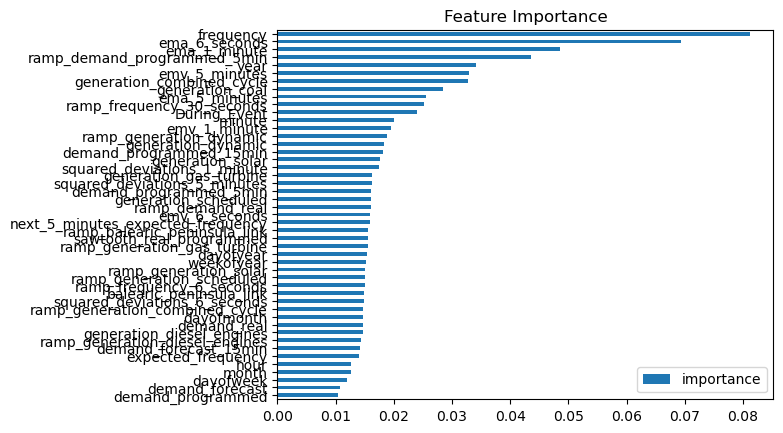

<Figure size 3000x3000 with 0 Axes>

In [218]:
fi = pd.DataFrame(data=classifier.feature_importances_,
             index=classifier.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

plt.figure(figsize=(30, 30))
plt.show()

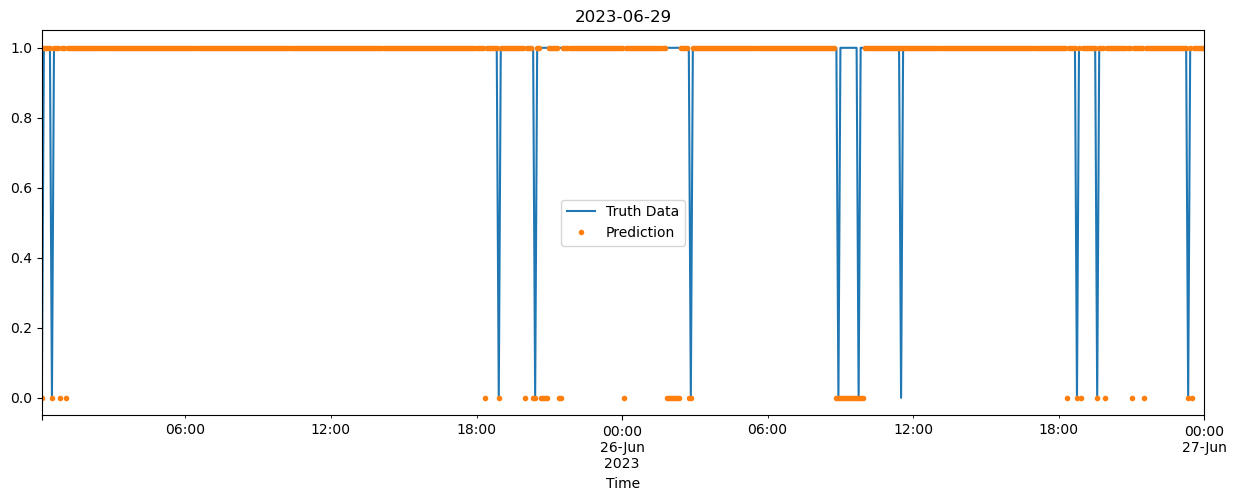

In [219]:
plot_prediction = test_data.copy()
plot_prediction["prediction"] = classifier.predict(X_test)
df = filtered_data.merge(plot_prediction[['prediction']], how='left', left_index=True, right_index=True)


ax = df.loc[(df.index > '2023-06-25') & (df.index <= '2023-06-27')]['event_pred'] \
    .plot(figsize=(15, 5), title='2023-06-29')
df.loc[(df.index > '2023-06-25') & (df.index <= '2023-06-27')]['prediction'] \
    .plot(style='.')
#df.loc[(df.index > '2023-06-25') & (df.index <= '2023-06-27')]['During_Event'] \
#    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

good day vs a bad day and put it on the frequency data

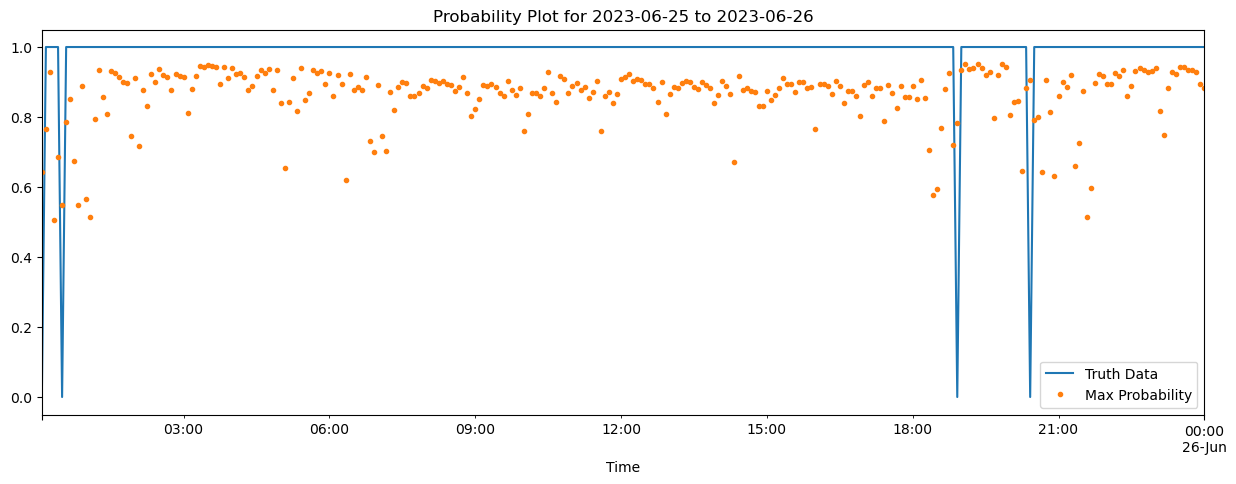

In [220]:
probabilities = classifier.predict_proba(X_test)

plot_prediction['max_probability'] = probabilities.max(axis=1)

df = filtered_data.merge(plot_prediction[['max_probability']], how='left', left_index=True, right_index=True)

import matplotlib.pyplot as plt

ax = df.loc[(df.index > '2023-06-25') & (df.index <= '2023-06-26')]['event_pred'] \
    .plot(figsize=(15, 5), title='Probability Plot for 2023-06-25 to 2023-06-26')

df.loc[(df.index > '2023-06-25') & (df.index <= '2023-06-26')]['max_probability'] \
    .plot(style='.')

plt.legend(['Truth Data', 'Max Probability'])
plt.show()


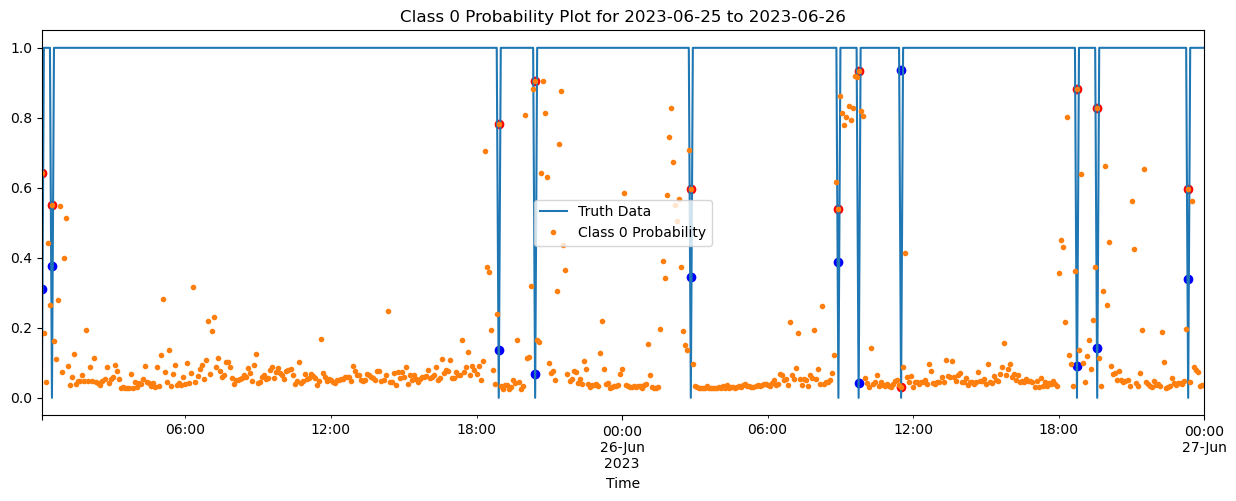

In [221]:
# Getting probabilities for class 0
class_0_probabilities = classifier.predict_proba(X_test)[:, 0]
plot_prediction['class_0_probability'] = class_0_probabilities

class_1_probabilities = classifier.predict_proba(X_test)[:, 1]
plot_prediction['class_1_probability'] = class_1_probabilities

df = filtered_data.merge(plot_prediction[['class_0_probability']], how='left', left_index=True, right_index=True)
df = df.merge(plot_prediction[['class_1_probability']], how='left', left_index=True, right_index=True)
import matplotlib.pyplot as plt

ax = df.loc[(df.index > '2023-06-25') & (df.index <= '2023-06-27')]['event_pred'] \
    .plot(figsize=(15, 5), title='Class 0 Probability Plot for 2023-06-25 to 2023-06-26')

df.loc[(df.index > '2023-06-25') & (df.index <= '2023-06-27')]['class_0_probability'] \
    .plot(style='.')

special_points = df[df['event_pred'] == 0]



plt.scatter(special_points.index, special_points['class_0_probability'], color='red')
plt.scatter(special_points.index, special_points['class_1_probability'], color='blue')

plt.legend(['Truth Data', 'Class 0 Probability'])
plt.show()


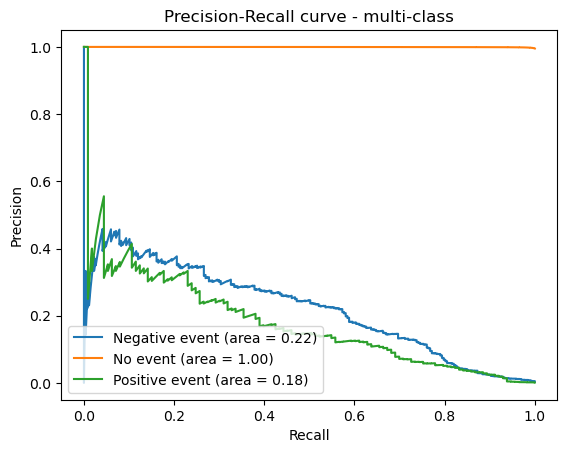

In [356]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

probabilities = classifier.predict_proba(X_test)

# Number of classes
n_classes = probabilities.shape[1]

label = ['Negative event', 'No event', 'Positive event']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, probabilities[:, i])
    roc_auc[i] = roc_auc_score(y_test == i, probabilities[:, i])

# Compute Precision-Recall curve and area for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, probabilities[:, i])
    average_precision[i] = average_precision_score(y_test == i, probabilities[:, i])

# Plot all ROC curves
plt.figure(1)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - multi-class')
plt.legend(loc="lower right")

# Plot all Precision-Recall curves
plt.figure(2)
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'{label[i]} (area = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - multi-class')
plt.legend(loc="lower left")

plt.savefig(f'plots/pr_curve.pdf', format='pdf')

plt.show()


In [350]:
y_pred = classifier.predict(X_test)

histogram_df = X_test.copy()
histogram_df["day"] = histogram_df["dayofmonth"]

histogram_df['datetime'] = pd.to_datetime(histogram_df[['year', 'month', 'day', 'hour', 'minute']])

histogram_df["event_pred"] = y_test


false_positives_indices = np.where((y_pred != y_test) & (y_pred != 1))[0]

event_datetimes = histogram_df[histogram_df['event_pred'] != 1]['datetime']

distances_to_next_event = []

for index in false_positives_indices:
    fp_datetime = histogram_df.iloc[index]['datetime']
    time_differences = (event_datetimes - fp_datetime).dt.total_seconds() / 60.0
    future_events_within_30 = time_differences[(time_differences > 0) & (time_differences <= 180)]
    if not future_events_within_30.empty:
        # Find the minimum time difference to the next event
        min_diff_to_next_event = future_events_within_30.min()
        distances_to_next_event.append(min_diff_to_next_event)
    else:
        distances_to_next_event.append(None)  # Or some placeholder to indicate no upcoming event within 30 mins




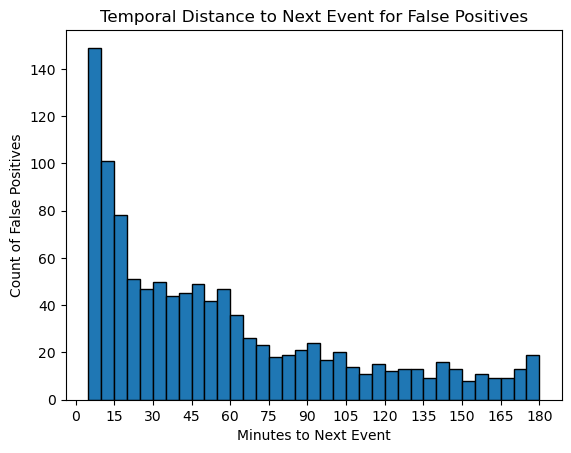

In [360]:
import numpy as np
import pandas as pd


# Separate false positives for classes 0 and 2
false_positives_indices_0 = np.where((y_pred != y_test) & (y_pred == 0))[0]
false_positives_indices_2 = np.where((y_pred != y_test) & (y_pred == 2))[0]

# Combine false positive indices for more general processing
combined_false_positives_indices = {
    'class_0': false_positives_indices_0,
    'class_2': false_positives_indices_2
}

# Prepare the event_datetimes for non-event (non-class 1) predictions
event_datetimes = histogram_df[histogram_df['event_pred'] != 1]['datetime']

# Initialize an empty list to store distances
distances_to_next_event = []

# Process false positives for each class separately
for class_label, indices in combined_false_positives_indices.items():
    for index in indices:
        fp_datetime = histogram_df.iloc[index]['datetime']
        time_differences = (event_datetimes - fp_datetime).dt.total_seconds() / 60.0
        # Filter to find future events within 30 minutes to 3 hours (180 minutes)
        future_events_within_30 = time_differences[(time_differences > 0) & (time_differences <= 180)]
        if not future_events_within_30.empty:
            # Find the minimum time difference to the next event
            min_diff_to_next_event = future_events_within_30.min()
            distances_to_next_event.append(min_diff_to_next_event)

# Now, distances_to_next_event contains the distances to the next event for false positives of classes 0 and 2 combined
            
# Calculate the number of bins for a 5-minute interval across the range of distances
min_distance = min(distances_to_next_event)
max_distance = max(distances_to_next_event)
range_of_distances = max_distance - min_distance
num_bins = int(np.ceil(range_of_distances / 5))  # 5 minutes per bin

plt.hist(distances_to_next_event, bins=num_bins, edgecolor='k')
plt.xlabel('Minutes to Next Event')
plt.ylabel('Count of False Positives')
plt.title('Temporal Distance to Next Event for False Positives')

# Set x-ticks to every 15 minutes within the range of your data
xticks_range = np.arange(0, max_distance + 15, 15)  # Adjust the step to 15 minutes
plt.xticks(xticks_range)
plt.savefig(f'plots/temporal_distance_false_positve.pdf', format='pdf') 
plt.show()


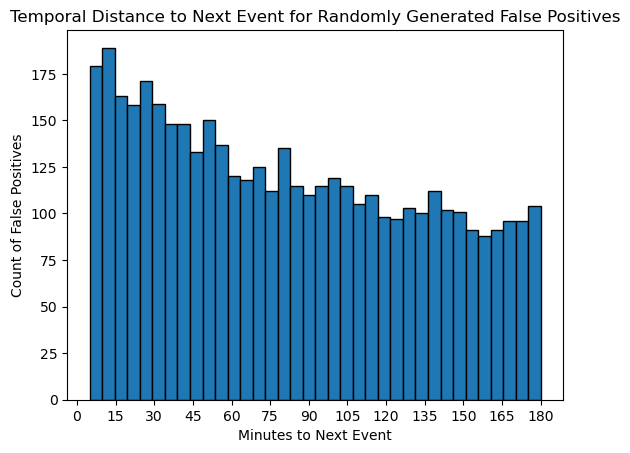

In [363]:
y_pred = classifier.predict(X_test)

histogram_df = X_test.copy()
histogram_df["day"] = histogram_df["dayofmonth"]

histogram_df['datetime'] = pd.to_datetime(histogram_df[['year', 'month', 'day', 'hour', 'minute']])

histogram_df["event_pred"] = y_test


actual_false_positives_indices = np.where((y_pred != y_test) & (y_pred != 1))[0]
num_false_positives = len(actual_false_positives_indices)

num_instances = len(y_test)  # Total number of instances in the dataset
# random_false_positives_indices = np.random.choice(num_instances, num_false_positives, replace=False)
random_false_positives_indices = np.random.choice(num_instances, 40000, replace=False)


event_datetimes = histogram_df[histogram_df['event_pred'] != 1]['datetime']

distances_to_next_event = []

for index in random_false_positives_indices:
    fp_datetime = histogram_df.iloc[index]['datetime']
    time_differences = (event_datetimes - fp_datetime).dt.total_seconds() / 60.0
    future_events_within_30 = time_differences[(time_differences > 0) & (time_differences <= 180)]
    if not future_events_within_30.empty:
        # Find the minimum time difference to the next event
        min_diff_to_next_event = future_events_within_30.min()
        distances_to_next_event.append(min_diff_to_next_event)
    else:
        distances_to_next_event.append(None)  # Or some placeholder to indicate no upcoming event within 30 mins

distances_to_next_event = [d for d in distances_to_next_event if d is not None]

# Calculate the number of bins for a 5-minute interval across the range of distances
min_distance = min(distances_to_next_event)
max_distance = max(distances_to_next_event)
range_of_distances = max_distance - min_distance
num_bins = int(np.ceil( 180 / 5))  # 5 minutes per bin

plt.hist(distances_to_next_event, bins=num_bins, edgecolor='k')
plt.xlabel('Minutes to Next Event')
plt.ylabel('Count of False Positives')
plt.title('Temporal Distance to Next Event for Randomly Generated False Positives')

# Set x-ticks to every 15 minutes within the range of your data
xticks_range = np.arange(0, max_distance + 15, 15)  # Adjust the step to 15 minutes
plt.xticks(xticks_range)

plt.savefig(f'plots/temporal_distance_random_false_positve.pdf', format='pdf')


plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

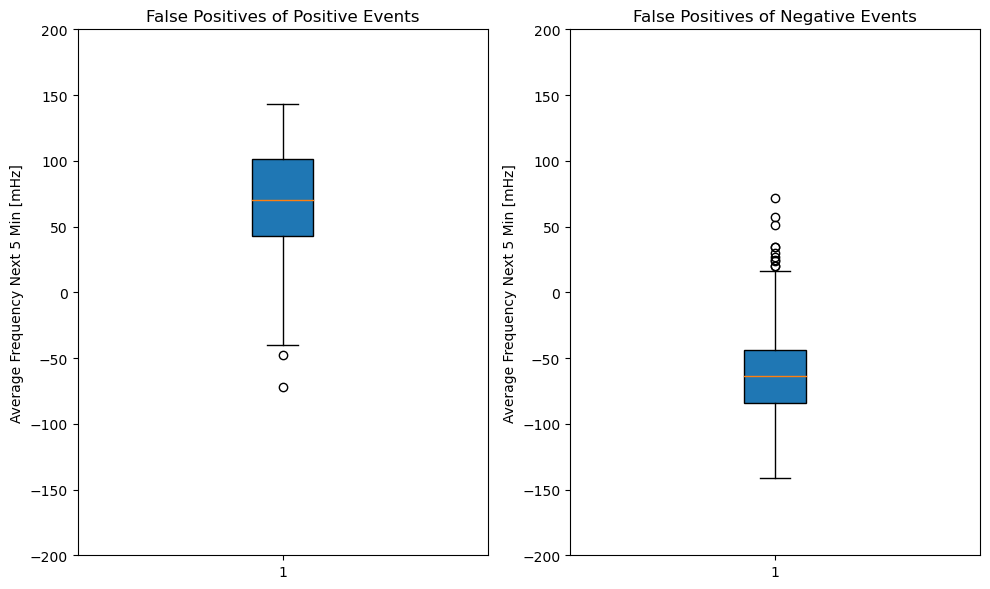

In [354]:
false_positives_indices_negative_events = np.where((y_pred != y_test) & (y_pred == 0))[0]

false_positives_indices_positve_events = np.where((y_pred != y_test) & (y_pred == 2))[0]

# Step 1: Filter the histogram_df for false positive instances for positive and negative events
false_positive_df = histogram_df.iloc[false_positives_indices]
positive_events_fp = histogram_df.iloc[false_positives_indices_positve_events]  # Positive events classified incorrectly
negative_events_fp = histogram_df.iloc[false_positives_indices_negative_events]  # Negative events classified incorrectly

# Convert the 'datetime' column to be timezone-aware, matching 'frequency_data'
positive_events_fp['datetime'] = positive_events_fp['datetime'].dt.tz_localize('Europe/Madrid')
negative_events_fp['datetime'] = negative_events_fp['datetime'].dt.tz_localize('Europe/Madrid')


# Function to calculate the average frequency over the next 5 minutes for a given datetime
def calculate_average_frequency(dt, frequency_df):
    end_time = dt + pd.Timedelta(minutes=5)
    freq_range = frequency_df.loc[dt:end_time]
    return freq_range['frequency'].mean()

# Step 2: Calculate average frequencies for the next 5 minutes for each false positive event
positive_events_fp['avg_frequency_next_5min'] = positive_events_fp['datetime'].apply(lambda x: calculate_average_frequency(x, frequency_data))
negative_events_fp['avg_frequency_next_5min'] = negative_events_fp['datetime'].apply(lambda x: calculate_average_frequency(x, frequency_data))

# Step 3: Plot the box plots for positive and negative false positive events
plt.figure(figsize=(10, 6))

# Box plot for positive events
plt.subplot(1, 2, 1)
plt.boxplot(positive_events_fp['avg_frequency_next_5min'].dropna(), patch_artist=True)
plt.title('False Positives of Positive Events')
plt.ylabel('Average Frequency Next 5 Min [mHz]')
plt.ylim(-200,200)

# Box plot for negative events
plt.subplot(1, 2, 2)
plt.boxplot(negative_events_fp['avg_frequency_next_5min'].dropna(), patch_artist=True)
plt.title('False Positives of Negative Events')
plt.ylabel('Average Frequency Next 5 Min [mHz]')
plt.ylim(-200,200)

plt.tight_layout()

plt.savefig(f'plots/boxplot_false_positives.pdf', format='pdf') 

plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

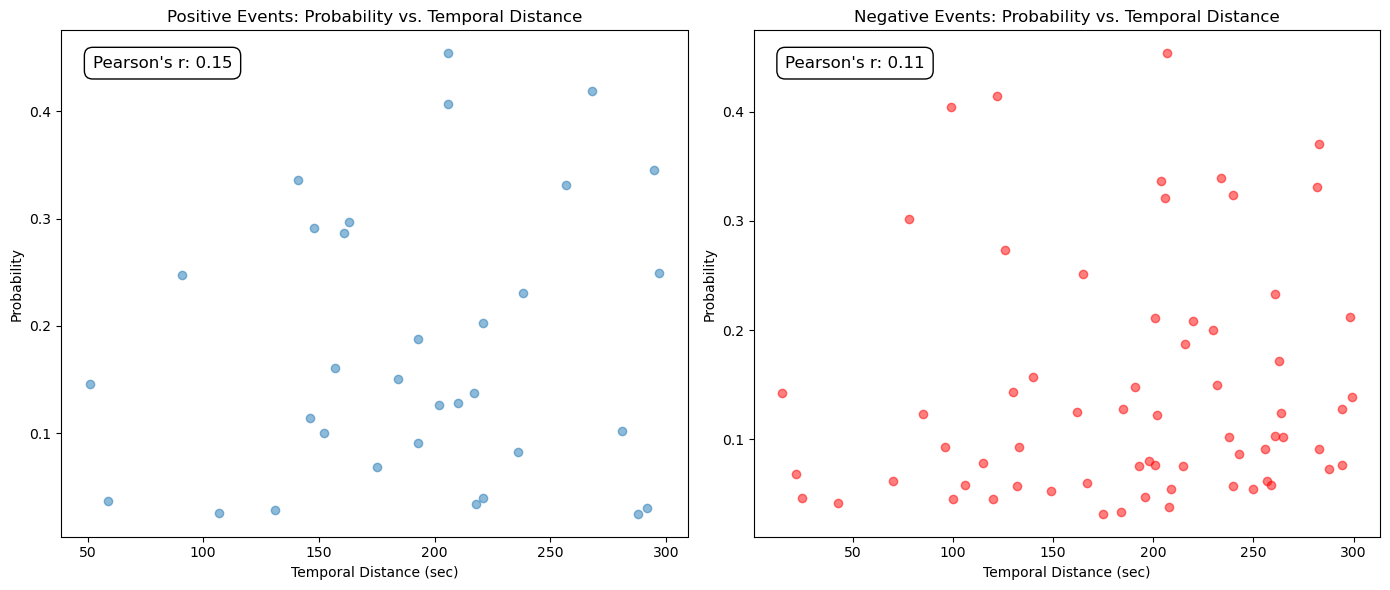

In [335]:
true_positives_indices_negative_events = np.where((0 == y_test) & (y_pred == 1))[0]

true_positives_indices_positve_events = np.where((2 == y_test) & (y_pred == 1))[0]

positive_events_fp = histogram_df.iloc[true_positives_indices_positve_events]  # Positive events classified correctly
negative_events_fp = histogram_df.iloc[true_positives_indices_negative_events]  # Negative events classified correctly

# Convert the 'datetime' column to be timezone-aware, matching 'frequency_data'
positive_events_fp['datetime'] = positive_events_fp['datetime'].dt.tz_localize('Europe/Madrid')
negative_events_fp['datetime'] = negative_events_fp['datetime'].dt.tz_localize('Europe/Madrid')


def find_first_datetime_above_threshold_positive(dt,frequency_df):
    end_time = dt + pd.Timedelta(minutes=5)
    freq_range = frequency_df.loc[dt:end_time]
    # Identifying points where frequency exceeds the threshold
    exceeds_threshold = freq_range['frequency'] >= 150

    # Finding the first occurrence where frequency exceeds the threshold
    return exceeds_threshold.idxmax()

def find_first_datetime_above_threshold_negative(dt,frequency_df):
    end_time = dt + pd.Timedelta(minutes=5)
    freq_range = frequency_df.loc[dt:end_time]
    # Identifying points where frequency exceeds the threshold
    exceeds_threshold = freq_range['frequency'] <= -150

    
    # Finding the first occurrence where frequency exceeds the threshold
    return exceeds_threshold.idxmax()



# Step 2: Calculate average frequencies for the next 5 minutes for each false positive event
positive_events_fp['Start'] = positive_events_fp['datetime'].apply(lambda x: find_first_datetime_above_threshold_positive(x, frequency_data))
negative_events_fp['Start'] = negative_events_fp['datetime'].apply(lambda x: find_first_datetime_above_threshold_negative(x, frequency_data))


positive_events_fp['Temporal_Distance_Sec'] = (positive_events_fp['Start'] - positive_events_fp['datetime']).dt.total_seconds().abs()
negative_events_fp['Temporal_Distance_Sec'] = (negative_events_fp['Start'] - negative_events_fp['datetime']).dt.total_seconds().abs()

X_test_copy = X_test.copy()
X_test_copy['class_0_probability'] = classifier.predict_proba(X_test)[:, 0]
X_test_copy['class_2_probability'] = classifier.predict_proba(X_test)[:, 2]


positive_events_fp['Probability'] = X_test_copy.iloc[true_positives_indices_positve_events]['class_2_probability'].values
negative_events_fp['Probability'] = X_test_copy.iloc[true_positives_indices_negative_events]['class_0_probability'].values



# For Positive Events
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(positive_events_fp['Temporal_Distance_Sec'], positive_events_fp['Probability'], alpha=0.5)
plt.title('Positive Events: Probability vs. Temporal Distance')
plt.xlabel('Temporal Distance (sec)')
plt.ylabel('Probability')

# Calculate and display Pearson correlation coefficient for positive events
correlation_coef_positive, _ = scipy.stats.pearsonr(positive_events_fp['Temporal_Distance_Sec'], positive_events_fp['Probability'])
plt.annotate(f"Pearson's r: {correlation_coef_positive:.2f}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, 
             color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# For Negative Events
plt.subplot(1, 2, 2)
plt.scatter(negative_events_fp['Temporal_Distance_Sec'], negative_events_fp['Probability'], alpha=0.5, color='red')
plt.title('Negative Events: Probability vs. Temporal Distance')
plt.xlabel('Temporal Distance (sec)')
plt.ylabel('Probability')

# Calculate and display Pearson correlation coefficient for negative events
correlation_coef_negative, _ = scipy.stats.pearsonr(negative_events_fp['Temporal_Distance_Sec'], negative_events_fp['Probability'])
plt.annotate(f"Pearson's r: {correlation_coef_negative:.2f}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, 
             color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


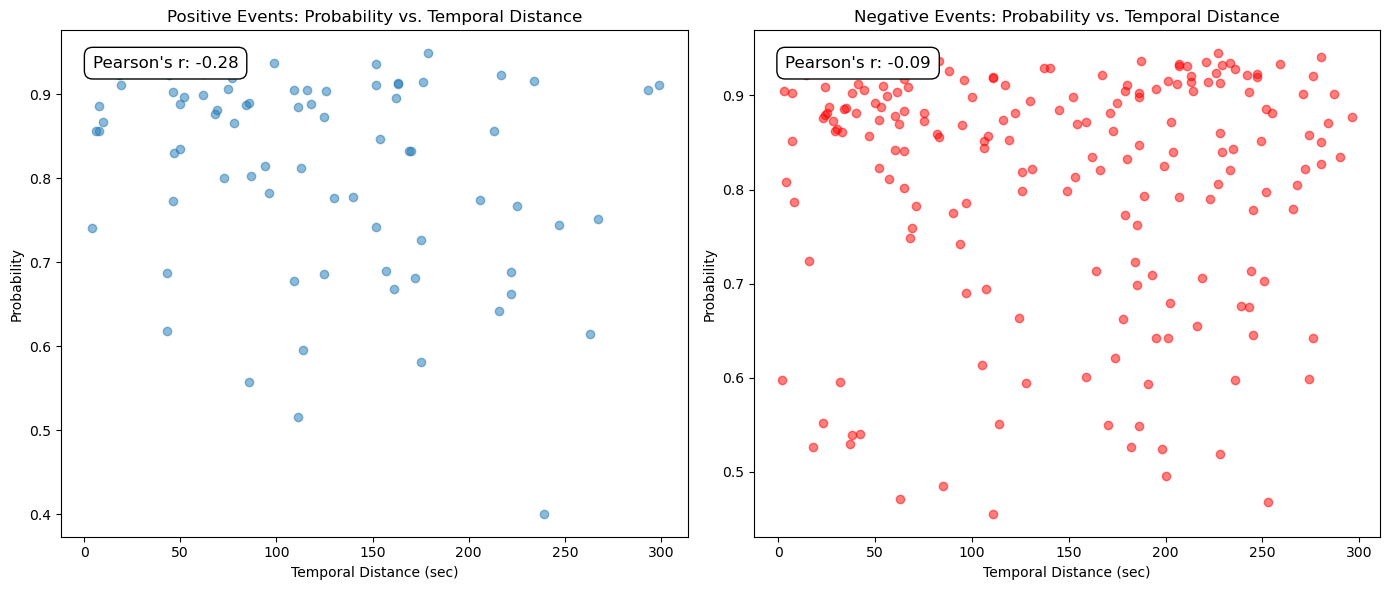

In [337]:
import scipy.stats


# For Positive Events
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(positive_events_fp['Temporal_Distance_Sec'], positive_events_fp['Probability'], alpha=0.5)
plt.title('Positive Events: Probability vs. Temporal Distance')
plt.xlabel('Temporal Distance (sec)')
plt.ylabel('Probability')

# Calculate and display Pearson correlation coefficient for positive events
correlation_coef_positive, _ = scipy.stats.pearsonr(positive_events_fp['Temporal_Distance_Sec'], positive_events_fp['Probability'])
plt.annotate(f"Pearson's r: {correlation_coef_positive:.2f}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, 
             color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# For Negative Events
plt.subplot(1, 2, 2)
plt.scatter(negative_events_fp['Temporal_Distance_Sec'], negative_events_fp['Probability'], alpha=0.5, color='red')
plt.title('Negative Events: Probability vs. Temporal Distance')
plt.xlabel('Temporal Distance (sec)')
plt.ylabel('Probability')

# Calculate and display Pearson correlation coefficient for negative events
correlation_coef_negative, _ = scipy.stats.pearsonr(negative_events_fp['Temporal_Distance_Sec'], negative_events_fp['Probability'])
plt.annotate(f"Pearson's r: {correlation_coef_negative:.2f}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, 
             color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


In [368]:
# create the samples for the shap values

y_test_df = y_test.to_frame(name='label')
X_test_df = pd.DataFrame(X_test)

# Combine X_test and y_test for easier filtering
test_combined = pd.concat([X_test_df, y_test_df], axis=1)

# Filter samples for each class
sample_class_0 = test_combined[test_combined['label'] == 0].sample(75)
sample_class_1 = test_combined[test_combined['label'] == 1].sample(100)
sample_class_2 = test_combined[test_combined['label'] == 2].sample(75)

sample_test_combined = pd.concat([sample_class_0, sample_class_1, sample_class_2])

sample_X_test = sample_test_combined.drop('label', axis=1)
sample_y_test = sample_test_combined['label']

In [367]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(
    classifier, sample_X_test, feature_perturbation='interventional', check_additivity=False)


# Compute SHAP values
shap_values = explainer.shap_values(X_test)

In [244]:
import joblib

# Save the model to disk
joblib.dump(shap_values, 'shap_values.lib')

In [245]:
joblib.dump(X_test, "test_data.lib")